# Basic SEGY file editing with segyio and scipy.signal

This notebook provides a quicklook to standard segy manipulation such as:
- Trace resampling
- Time cut

Segy writing is also described at the end of the notebook. The 2D seismic line in this post is from the [USGS NPRA Seismic Data Archive](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx), and are in the public domain. The line number is 3X_75_PR.

### Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import segyio


filename = '3X_75_PR.SGY'

## Inspect file
After reading the file, we get some of the basic attributes of the file§

In [2]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 1592, N Samples: 751, Sample rate: 8.0ms, Trace length: 6000.0'

The segy file has a sampling rate of 8.0m and a length of 6 seconds. We want to cut the file at 4000ms and set the sampling rate at 16ms. This should result in a 251 samples per trace file.

The following plotting function will be used for illustration in the next sections

In [3]:
def plot_segy(file):
    # Load data
    with segyio.open(file, ignore_geometry=True) as f:
        # Get basic attributes
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:]
    # Plot
    plt.style.use('ggplot')  # Use ggplot styles for all plotting
    vm = np.percentile(data, 99)
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    extent = [1, n_traces, twt[-1], twt[0]]  # define extent
    ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
    ax.set_xlabel('CDP number')
    ax.set_ylabel('TWT [ms]')
    ax.set_title(f'{file}')

## Cut all traces

In [4]:
# Setup the destination file
destination = 'Cut.SGY'
# Define the sample index to cut on
cut_time = 4000
cut_sample = int(cut_time / sample_rate)+1

With the input file opened, we create the destination file, then copy all specifications until the cut sample. We finally have to update the bin header to insert the correct trace length.

In [5]:
with segyio.open(filename, ignore_geometry=True) as src:
    spec = segyio.tools.metadata(src)
    spec.samples = spec.samples[:cut_sample]
    with segyio.create(destination, spec) as dst:
        dst.text[0] = src.text[0]
        dst.bin = src.bin
        dst.bin.update(hns=len(spec.samples))
        dst.header = src.header
        dst.trace = src.trace

### Plot original file 

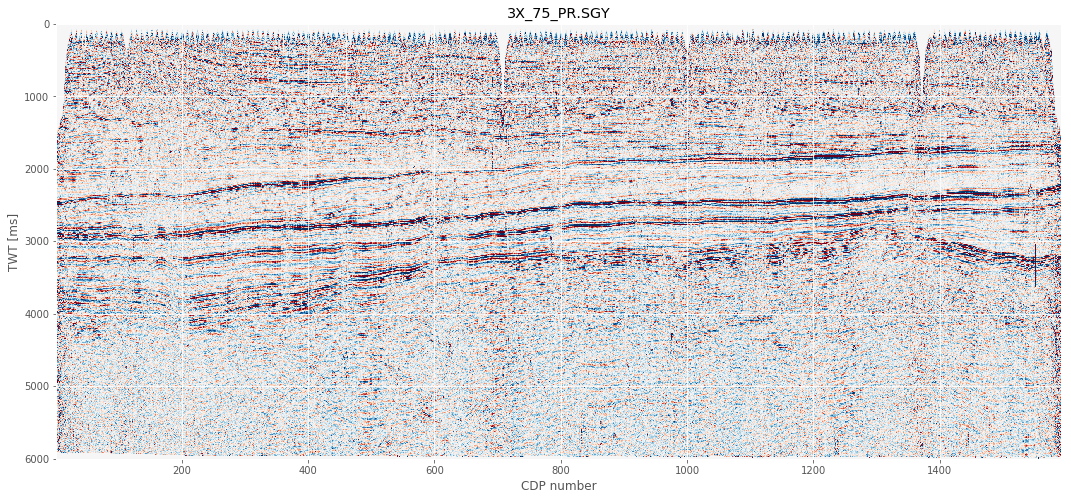

In [6]:
plot_segy(filename)

### Plot cut file

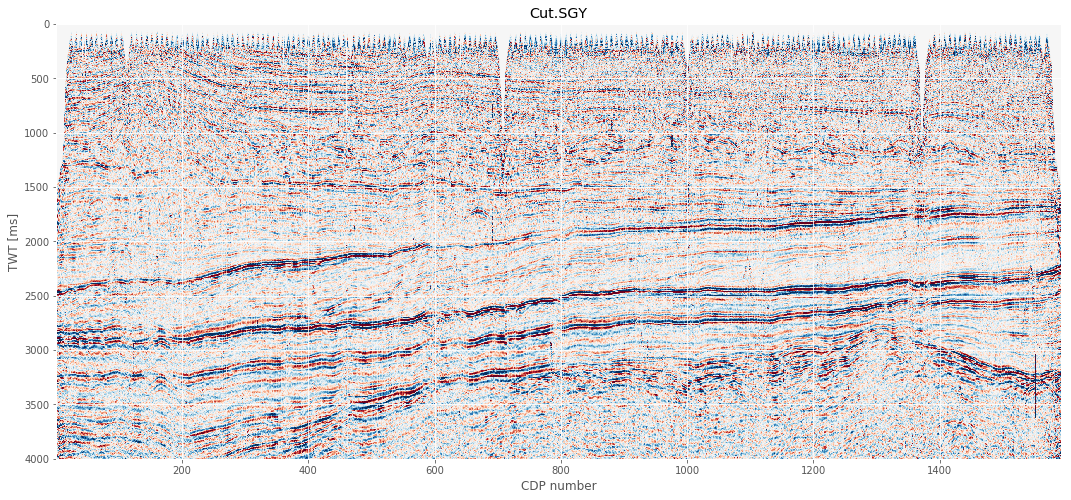

In [7]:
plot_segy(destination)

## Resample the traces
Once the trace are resampled, we need to update the sampling rate and number of sample in the bin header.

In [9]:
final = 'test_resample.SGY'
new_sampling = 16  # Should be a multiple of the original sampling rate
sampling_ratio = int(new_sampling/sample_rate)

import numpy as np

with segyio.open(destination, ignore_geometry=True) as src:
    spec = segyio.tools.metadata(src)
    spec.samples = spec.samples[:int(src.samples.size/2)]
    with segyio.create(final, spec) as dst:
        dst.text[0] = src.text[0]
        dst.bin = src.bin      
        for ix, trace in enumerate(src.trace):
            dst.trace[ix] =  scipy.signal.resample(trace, int(len(trace)/2))
        dst.bin.update(hdt=new_sampling*1000)
        dst.bin.update(hns=len(spec.samples))
        dst.header = src.header


c:\python37\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
c:\python37\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
c:\python37\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

### Plot final resampled file

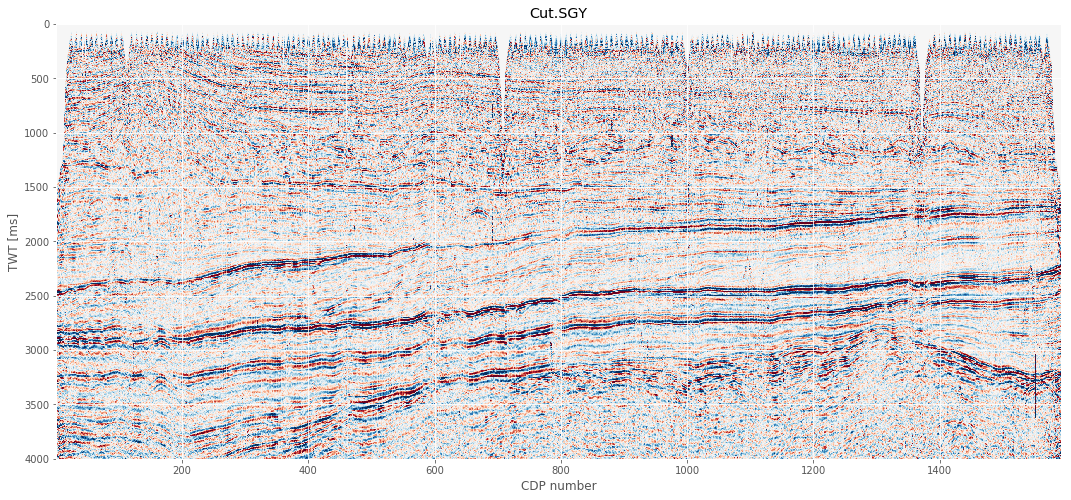

In [8]:
plot_segy(destination)